# 利用智能优化算法优化神经网络参数

In [1]:
import datetime as dt
import os
import warnings
import math
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils import weight_norm

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

In [55]:
import sys
path = 'D:/Jupyter notebook/src/01.python/04.实践应用/02.运筹优化/models' #智能优化算法所在文件夹
sys.path.insert(0, path)

## 加载数据集

In [46]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [1]:
# 包含时间维度的数据集划分
def divide_dataset(df, test_date, valid_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [48]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [49]:
#利用前lookback个数据，预测下delay个数据
def rnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X) # X为三维
    y = torch.as_tensor(y) 
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [50]:
# # 构造参数字典
# params2 = {
#     "lookback": 6,
#     "delay": 1,
#     "step": 1, 
#     "batch_size": 32,
# }
# X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
# X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
# X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
# print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
# print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
# print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

## 定义模型

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_dim, out_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=out_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_output = lstm_out
        output = self.linear(last_time_step_output)
        return output

## 定义适应度函数

In [52]:
# 适应度函数
model = None # 定义全局变量
def fitness(X):
    """超参数初始化"""
    # 数据划分初始化
    data_args = {"lookback": int(X[0]), "delay": 1, "step": 1, "batch_size": int(X[1])}
    _, _, train_loader = rnn_create_dataset(x_train, y_train, **data_args)
    _, _, valid_loader = rnn_create_dataset(x_valid, y_valid, **data_args)
    
    # 外部参数初始化
    learning_rate = X[2]
    n_epochs = int(X[3]) # 需要整数化
    
    # 模型参数初始化
    lstm_args = {"input_dim": 2, "out_dim": 1, "hidden_dim": int(X[4])}
    global model
    model = LSTM(**lstm_args)
    
    """模型训练"""
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 设置参数优化策略
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            
            # 清空梯度
            optimizer.zero_grad()
            
            # 前向传播
            train_outputs = model(inputs_batch)
            train_outputs = train_outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(train_outputs, targets_batch)
            
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
                
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                
                # 前向传播
                val_outputs = model(inputs_batch)[:,-1, -1:]
                val_loss = loss_fn(val_outputs, targets_batch)
                
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #打印训练过程
        verbose = False
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
    return avg_val_loss # 适应度值，如果任务是最大化，将适应度值加负号即可

## 智能优化算法

### 鲸鱼优化算法

In [13]:
import WOA # 加载本地鲸鱼优化算法

# 构造参数字典
woa_args = {
    "pop": 20, # 种群数量，需遍历
    "dim": 5, # 优化参数维度
    "lb": np.array([3, 16, 0.001, 5, 8]), # 下边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "ub": np.array([20, 64, 0.01, 20, 32]), # 上边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "fun": fitness, # 适应度函数，最小化问题
    "MaxIter": 30, # 最大迭代次数，需遍历
}

#函数传参，运行次数：pop*MaxIter*n_epochs
GbestScore,GbestPositon,Curve = WOA.WOA(**woa_args)

第0次迭代
第1次迭代
第2次迭代
第3次迭代
第4次迭代
第5次迭代
第6次迭代
第7次迭代
第8次迭代
第9次迭代
第10次迭代
第11次迭代
第12次迭代
第13次迭代
第14次迭代
第15次迭代
第16次迭代
第17次迭代
第18次迭代
第19次迭代
第20次迭代
第21次迭代
第22次迭代
第23次迭代
第24次迭代
第25次迭代
第26次迭代
第27次迭代
第28次迭代
第29次迭代


In [14]:
x1, x2, x3, x4, x5 = GbestPositon[0]
print('最优适应度值：',GbestScore)
print('最优解[滞后量]：', int(x1))
print('最优解[批量大小]：', int(x2))
print('最优解[学习率]：', x3)
print('最优解[迭代次数]：', int(x4))
print('最优解[隐藏层数]：', int(x5))

最优适应度值： [0.]
最优解[滞后量]： 20
最优解[批量大小]： 41
最优解[学习率]： 0.01
最优解[迭代次数]： 11
最优解[隐藏层数]： 19


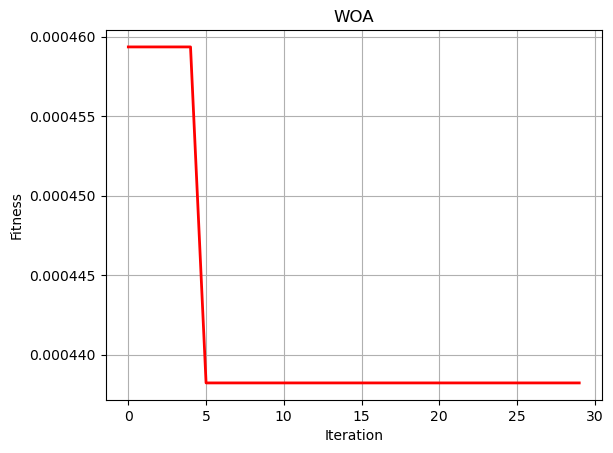

In [15]:
#绘制适应度曲线
plt.figure(1)
plt.plot(Curve,'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('WOA',fontsize='large')
plt.show()

### 遗传算法

In [34]:
from sko.GA import GA

# 构造参数字典
ga_args = {
    "func": fitness, # 适应度函数，最小化问题
    "n_dim": 5, # 优化参数维度
    "lb": [3, 16, 0.001, 5, 8], # 下边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "ub": [20, 64, 0.01, 20, 32], # 上边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "size_pop": 10, 
    "max_iter": 20, # 最大迭代次数，需遍历
    "prob_mut": 0.001,
    "precision": 1e-7
}

#函数传参，运行次数：size_pop*max_iter*n_epochs
ga = GA(**ga_args)

# 执行优化程序
best_x, best_y = ga.run()

size_pop: 10, Lind: [28 29 17 28 28]


In [35]:
x1, x2, x3, x4, x5 = best_x
print('最优适应度值：',best_y)
print('最优解[滞后量]：', int(x1))
print('最优解[批量大小]：', int(x2))
print('最优解[学习率]：', x3)
print('最优解[迭代次数]：', int(x4))
print('最优解[隐藏层数]：', int(x5))

最优适应度值： [0.]
最优解[滞后量]： 9
最优解[批量大小]： 38
最优解[学习率]： 0.0041612027069298325
最优解[迭代次数]： 17
最优解[隐藏层数]： 17


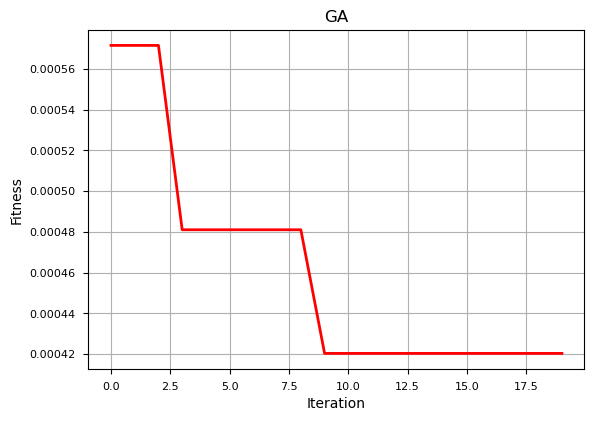

In [39]:
#绘制适应度曲线
Y_history = pd.DataFrame(ga.all_history_Y)
plt.figure(1)
plt.plot(Y_history.min(axis=1).cummin(),'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('GA',fontsize='large')
plt.show()

### 麻雀搜索算法

In [58]:
import SSA # 加载本地算法

# 构造参数字典
ssa_args = {
    "pop": 10, # 种群数量，需遍历
    "dim": 5, # 优化参数维度
    "lb": np.array([3, 16, 0.001, 5, 8]), # 下边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "ub": np.array([20, 64, 0.01, 20, 32]), # 上边界，分别为滞后量、批量大小、学习率，迭代次数、隐藏层数
    "fun": fitness, # 适应度函数，最小化问题
    "Max_iter": 5, # 最大迭代次数，需遍历
}

#函数传参，运行次数：pop*Max_iter*n_epochs
GbestScore, GbestPositon, Curve = SSA.SSA(**ssa_args)

第0次迭代
第1次迭代
第2次迭代
第3次迭代
第4次迭代


In [59]:
x1, x2, x3, x4, x5 = GbestPositon[0]
print('最优适应度值：',GbestScore)
print('最优解[滞后量]：', int(x1))
print('最优解[批量大小]：', int(x2))
print('最优解[学习率]：', x3)
print('最优解[迭代次数]：', int(x4))
print('最优解[隐藏层数]：', int(x5))

最优适应度值： [0.]
最优解[滞后量]： 11
最优解[批量大小]： 30
最优解[学习率]： 0.003897927868600384
最优解[迭代次数]： 18
最优解[隐藏层数]： 21


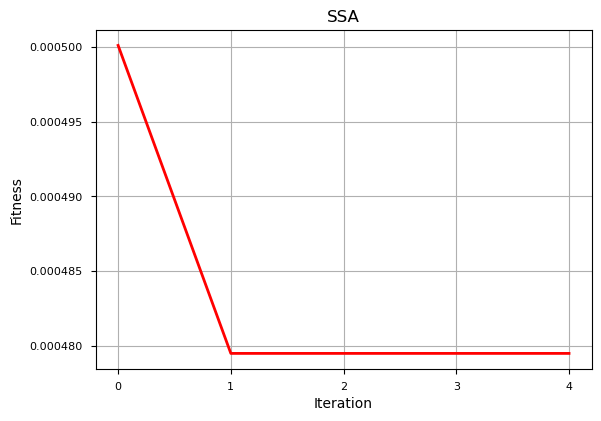

In [61]:
#绘制适应度曲线
plt.figure(1)
plt.plot(Curve,'r-',linewidth=2)
# 设置X轴刻度为整数
plt.locator_params(axis='x', integer=True)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('SSA',fontsize='large')
plt.show()

## 模型预测

In [62]:
# 构造参数字典
params2 = {
    "lookback": int(x1),
    "delay": 1,
    "step": 1, 
    "batch_size": int(x2),
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23365, 11, 2]),y_size: torch.Size([23365, 1]),loader_len: 779
X_size: torch.Size([1453, 11, 2]),y_size: torch.Size([1453, 1]),loader_len: 49
X_size: torch.Size([1453, 11, 2]),y_size: torch.Size([1453, 1]),loader_len: 49


In [63]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出，并将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [64]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": int(x1),
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

## 结果分析

In [65]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

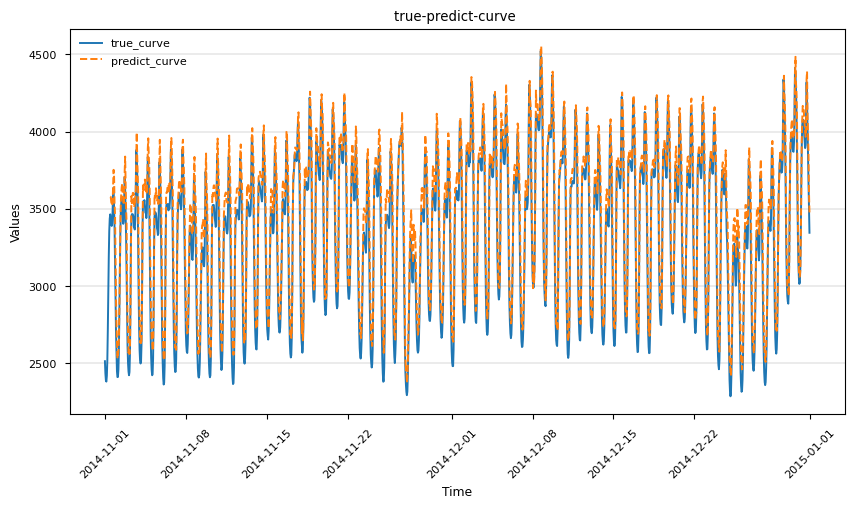

In [66]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)